In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

from tabulate import tabulate


In [2]:
%load_ext line_profiler

In [3]:
# #Set number of cycles
ncycles = 100

# Original Parameters
# #Set parameters
max_val = 1
min_val = -0.2
# rest_val = -0.1
decay_val = 0.1
estr_val = 0.4
# alpha_val = 0.1
# gamma_val = 0.1



# #Alternative Parameter Values
rest_val = -0.01
# estr_val = 0.45
alpha_val = 0.02
gamma_val = 0.02

In [4]:
def pool(n, name, type, nunits, unit_names, projections, weights, extInput=None):
    """
    n: pool number (numeric)
    name: name of pool (e.g., 'hidden') (string)
    type: type of pool (e.g., 'input') (string)
    nunits: number of units in pool (numeric)
    projections: list of pools (list)
    weights: list of weight matrices indexed by pool (list)
    extInput: external input to pool (optional, defaults to None)
    """
    if extInput is None:
        extInput = np.zeros((1, nunits))

    return {"pool_number": n,
        "name": name,
        "type": type, # hidden or input
        "nunits": nunits,
        "unit_names": unit_names,
        "projections": projections,
        "weights": weights,
        "extInput": extInput,
        "activation": np.zeros((1, nunits)),
        "inhibition": np.zeros((1, nunits)),
        "excitation": np.zeros((1, nunits)),
        "netInput": np.zeros((1, nunits)),
        "activation_history": []}


In [5]:
def set_extInput(pool_i, input):
    
    pool_i["extInput"] = np.array([input])
    
    return pool_i

In [6]:
# import data
f2F = pd.read_csv("csv_files/NBA_features2features_Medium.csv")
f2F.index = f2F.iloc[:, 0]
f2F = f2F.iloc[:, 1:]
f2F_df = f2F.copy()
f2F = np.array(f2F)
features_tuple = tuple(str(idx) for idx in f2F_df.index)
num_features = len(features_tuple)

In [7]:
num_features

33

In [8]:
features_tuple

('Forward',
 'Center',
 'Guard',
 'Under 6',
 '6 - 6_5',
 '6_5 - 6_11',
 '7 and Over',
 '18-24',
 '25-29',
 '30-34',
 '35+',
 'Round 1',
 'Round 2',
 'Undrafted',
 'Domestic',
 'International',
 'All_Star_Yes',
 'All_Star_No',
 'Atlanta Hawks',
 'Boston Celtics',
 'Brooklyn Nets',
 'Charlotte Hornets',
 'Chicago Bulls',
 'Cleveland Cavaliers',
 'Detroit Pistons',
 'Indiana Pacers',
 'Miami Heat',
 'Milwaukee Bucks',
 'New York Knicks',
 'Orlando Magic',
 'Philadelphia Sixers',
 'Toronto Raptors',
 'Washington Wizards')

In [9]:
# features to hidden matrix
f2H = pd.read_csv("csv_files/NBA_features2Hidden_Medium.csv", index_col=0)
f2H_df = f2H.copy()
f2H = f2H.fillna(0)
f2H = f2H.to_numpy()
names_tuple = tuple(str(idx) for idx in f2H_df.index)
num_players = len(names_tuple)

In [10]:
num_players

255

In [11]:
def run_simulation(pool_, ncycles):
    # Loop through the specified number of cycles
    for x in tqdm(range(ncycles)):
        # print('cycle x:',x)
        
        # Loop through each pool in the list
        for i in range(len(pool_)):
            
            # Initialize excitation and inhibition arrays for the current pool
            pool_[i]['excitation'] = np.zeros((1, pool_[i]['nunits']))
            pool_[i]['inhibition'] = np.zeros((1, pool_[i]['nunits']))

            # Loop through each sender pool
            for sender in pool_[i]['projections']:
                # Get indices of positive activations in the sender pool
                positive_acts_indices = np.argwhere(pool_[sender]['activation'] > 0)[:,1]

                # If there are positive activations, process them
                if len(positive_acts_indices) > 0:
                    for k in range(len(positive_acts_indices)):
                        
                        # Get index of the positive activation
                        index = positive_acts_indices[k]
                        
                        # Get weights for the current sender and positive activation index
                        wts = pool_[i]['weights'][sender][index, :]
                        
                        # Get indices for excitatory and inhibitory weights
                        wts_e=np.argwhere([wts > 0])[:,1]
                        wts_i=np.argwhere([wts < 0])[:,1]

                        # Update excitation and inhibition values for the current pool
                        for w_e in wts_e: 
                            pool_[i]['excitation'][:,w_e] += pool_[sender]['activation'][:,index] * wts[w_e]                           
                        for w_i in wts_i:
                            pool_[i]['inhibition'][:,w_i] += pool_[sender]['activation'][:,index] * wts[w_i]
                        
            # Apply alpha and gamma factors to the excitation and inhibition values
            pool_[i]['excitation'] *= alpha_val
            pool_[i]['inhibition'] *= gamma_val
            
            # Calculate net input for the current pool
            pool_[i]['netInput'] = pool_[i]['excitation'] + pool_[i]['inhibition'] + estr_val * pool_[i]['extInput']

        # Loop through each pool in the list
        for i in range(len(pool_)):
            
            # Get indices of positive and non-positive net input values
            pns = np.argwhere(pool_[i]['netInput'] > 0)[:,1]
            nps = np.argwhere(pool_[i]['netInput'] <= 0)[:,1]

            # Update activation values for positive net input indices
            if len(pns) > 0:
                for p in pns:
                    pool_[i]['activation'][:,p] += (max_val - pool_[i]['activation'][:,p]) * pool_[i]['netInput'][:,p] - decay_val * (pool_[i]['activation'][:,p] - rest_val)
            
            # Update activation values for non-positive net input indices
            if len(nps) > 0:
                for n in nps:
                    pool_[i]['activation'][:,n] += (pool_[i]['activation'][:,n] - min_val) * pool_[i]['netInput'][:,n] - decay_val * (pool_[i]['activation'][:,n] - rest_val)
            
            # Clip activation values to the specified min and max values
            pool_[i]['activation'][pool_[i]['activation'] > max_val] = max_val
            pool_[i]['activation'][pool_[i]['activation'] < min_val] = min_val

            # Add the current activation values to the activation history
            pool_[i]['activation_history'].append(np.copy(pool_[i]['activation']))
    
    # Return the modified pool list after running the simulation
    return pool_

In [12]:
def plot_pools(pool_):

    # pool 1 features
    #a_history_1 = pool_[0]['activation_history']
    a_history_1=np.reshape(np.array(pool_[0]['activation_history']), [ncycles, num_features])
    unit_names_1 = pool_[0]['unit_names']
    m1 = pd.DataFrame(a_history_1)
    m1.columns = unit_names_1
    m1['step']=m1.index
    dfm1=m1.melt('step',var_name='Feature', value_name='Activation')

    fig1, ax = plt.subplots()
    for feature, group in dfm1.groupby('Feature'):
        ax.plot(group['step'], group['Activation'], marker='o', label=feature)
    ax.set_xlabel('Step')
    ax.set_ylabel('Activation')
    ax.set_ylim(min_val, max_val)
    ax.set_title('Activation of Feature Units by Cycle')
    # ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    # ax.legend()

    # pool 2 names
    a_history_2 = np.reshape(np.array(pool_[1]['activation_history']), [ncycles, num_players])
    unit_names_2 = pool_[1]['unit_names']
    m2 = pd.DataFrame(a_history_2)
    m2.columns = unit_names_2
    m2['step']=m2.index
    dfm2=m2.melt('step',var_name='Name', value_name='Activation')

    fig2, ax = plt.subplots()
    for feature, group in dfm2.groupby('Name'):
        ax.plot(group['step'], group['Activation'], marker='o', label=feature)
    ax.set_xlabel('Step')
    ax.set_ylabel('Activation')
    # ax.set_ylim(min_val, max_val)
    ax.set_title('Activation of Name Units by Cycle')
    # ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    # ax.legend()

    # pool 3 - hidden 
    a_history = np.reshape(np.array(pool_[2]['activation_history']), [ncycles, num_players])
    unit_names = pool_[2]['unit_names']
    m3 = pd.DataFrame(a_history)
    m3.columns = unit_names
    m3['step']=m3.index
    dfm3=m3.melt('step',var_name='Hidden_Unit', value_name='Activation')

    fig3, ax = plt.subplots()
    for feature, group in dfm3.groupby('Hidden_Unit'):
        ax.plot(group['step'], group['Activation'], marker='o', label=feature)
    ax.set_xlabel('Step')
    ax.set_ylabel('Activation')
    ax.set_ylim(min_val, max_val)
    ax.set_title('Activation of Hidden Units by Cycle')
    # ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    # ax.legend()

    return {"features": fig1, "names": fig2, "hidden": fig3}, dfm1, dfm2, dfm3


In [13]:
def rank_activations_by_pool(pool_):
    
    features_out = pool_[0]['activation'].flatten()
    features_names = pool_[0]['unit_names']
    features_df = pd.DataFrame({'feature': features_names, 'activation': features_out})
    features_df = features_df.sort_values(by=['activation'], ascending=False)
    
    names_out = pool_[1]['activation'].flatten()
    names_names = pool_[1]['unit_names']
    names_df = pd.DataFrame({'name': names_names, 'activation': names_out})
    names_df = names_df.sort_values(by=['activation'], ascending=False)
    
    hidden_out = pool_[2]['activation'].flatten()
    hidden_names = pool_[2]['unit_names']
    hidden_df = pd.DataFrame({'name': hidden_names, 'activation': hidden_out})
    hidden_df = hidden_df.sort_values(by=['activation'], ascending=False)
    
    return {'features': features_df, 'names': names_df, 'hidden': hidden_df}


In [14]:
# names to names

n2N = np.full((num_players, num_players), -1)
np.fill_diagonal(n2N, 0)
#n2N

In [15]:
# names to hidden
n2H = np.eye(num_players)
h2H = n2N

In [16]:
featurePool=pool(0, "features", "input", num_features, unit_names = list(features_tuple),projections = list((0,2)), weights = {0 : f2F,2 : f2H})
namePool=pool(1, "names", "input", num_players, unit_names = list(names_tuple),projections = list((1,2)), weights = {1 : n2N,2 : n2H})
hiddenPool=pool(2, "hidden", "hidden", num_players, unit_names = list(names_tuple),projections = list((0,1,2)), weights = {0:f2H.T, 1:n2H.T, 2:h2H})

In [17]:
df_players = pd.read_csv('csv_files/nba_players_medium.csv')
# print(tabulate(df_players, headers='keys', tablefmt='psql'))
df_players.head()

,Name,Position,Height,Age,Draft,Nationality,All_Star,Team
0,Precious Achiuwa,Forward,"6'5"" - 6'11""",18-24,Round 1,International,All_Star_No,Toronto Raptors
1,Bam Adebayo,Center,"6'5"" - 6'11""",25-29,Round 1,Domestic,All_Star_Yes,Miami Heat
2,Grayson Allen,Guard,"6' - 6'5""",25-29,Round 1,Domestic,All_Star_No,Milwaukee Bucks
3,Jarrett Allen,Center,"6'5"" - 6'11""",25-29,Round 1,Domestic,All_Star_No,Cleveland Cavaliers
4,Giannis Antetokounmpo,Forward,"6'5"" - 6'11""",25-29,Round 1,International,All_Star_Yes,Milwaukee Bucks


In [18]:
featurePool=set_extInput(featurePool, np.array([0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]))
namePool=set_extInput(namePool, np.zeros(num_players))

# blake_griffen_list = [0] * 255
# blake_griffen_list[81] = 1
# featurePool=set_extInput(featurePool, np.zeros(num_features))
# namePool=set_extInput(namePool, np.array(blake_griffen_list))

In [19]:
pool_= list((featurePool, namePool, hiddenPool))

In [20]:

pool_=run_simulation(pool_,ncycles)

  0%|          | 0/100 [00:00<?, ?it/s]

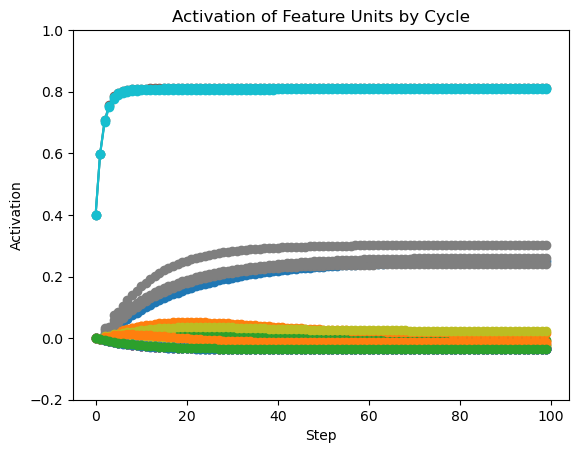

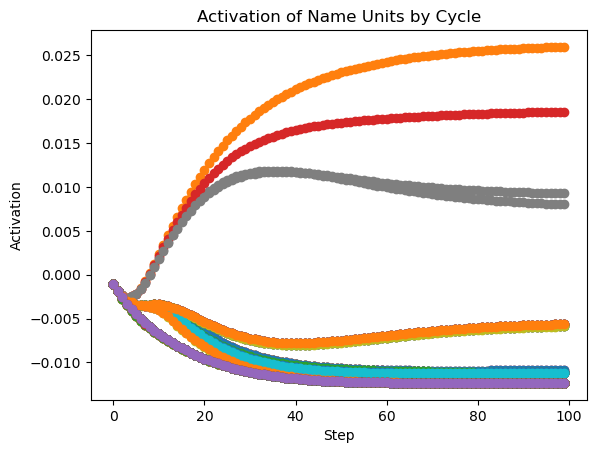

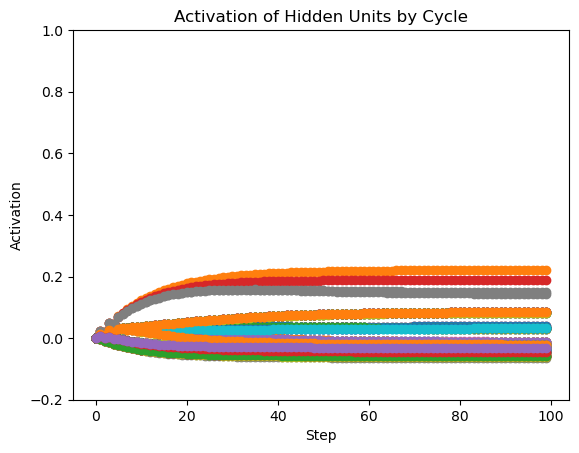

In [21]:
nnplot, df1, df2, df3 = plot_pools(pool_)

In [22]:
ranked_activations = rank_activations_by_pool(pool_)

names_table = ranked_activations['names']
names_table = names_table.reset_index(drop=True)  # Reset index to start from 0
names_table.insert(0, 'Rank', range(1, len(names_table) + 1))  # Add rank column
names_table_html = tabulate(names_table, headers='keys')  # Convert to HTML table

# Print the HTML table
# print(names_table_html)
names_table.head(20)

,Rank,name,activation
0,1,"A.J. Griffin, Jr.",0.025974
1,2,Tyrese Martin,0.018586
2,3,Vit Krejci,0.009284
3,4,Bogdan Bogdanovic,0.008027
4,5,R.J. Hampton,-0.005638
5,6,Patrick Williams,-0.005638
6,7,LaMelo Ball,-0.005638
7,8,MarJon Beauchamp,-0.005638
8,9,Dalen Terry,-0.005638
9,10,Tyler Herro,-0.005638


In [23]:
# Display the 'hidden' pool in a table
hidden_table = ranked_activations['hidden']
hidden_table = hidden_table.reset_index(drop=True)  # Reset index to start from 0
hidden_table.insert(0, 'Rank', range(1, len(hidden_table) + 1))  # Add rank column
hidden_table_html = tabulate(hidden_table, headers='keys')  # Convert to HTML table

# Print the HTML table
# print(hidden_table_html)
hidden_table.head(20)

,Rank,name,activation
0,1,"A.J. Griffin, Jr.",0.221257
1,2,Tyrese Martin,0.189378
2,3,Vit Krejci,0.149396
3,4,Bogdan Bogdanovic,0.143690
4,5,LaMelo Ball,0.084165
5,6,MarJon Beauchamp,0.084165
6,7,Dalen Terry,0.084165
7,8,Patrick Williams,0.084165
8,9,R.J. Hampton,0.084165
9,10,Tyler Herro,0.084165


In [24]:

feature_table = ranked_activations['features']
feature_table = feature_table.reset_index(drop=True)  # Reset index to start from 0
feature_table.insert(0, 'Rank', range(1, len(feature_table) + 1))  # Add rank column
#feature_table_html = tabulate(feature_table, headers='keys')  # Convert to HTML table

#Print feature table
# print(feature_table)
feature_table

,Rank,feature,activation
0,1,6_5 - 6_11,0.813481
1,2,Guard,0.812322
2,3,Atlanta Hawks,0.807401
3,4,All_Star_No,0.303345
4,5,Domestic,0.261728
5,6,18-24,0.249787
6,7,Round 1,0.240220
7,8,Round 2,0.024288
8,9,International,0.015956
9,10,30-34,-0.005557


In [25]:
# feature_table